# Pattern Lakehouse
Sujet de stage 2023

# Snowflake account connection

In [1]:
# ! pip freeze > requirements/requirements.txt

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from imblearn.over_sampling import SMOTE
import opendatasets as od
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from snowflake.snowpark import version
# from snowflake.snowpark.functions import udf, sproc, col
# from snowflake.snowpark.session import Session
# from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType, Variant

# print(f"Snowflake snowpark version is: {version.VERSION}")
import joblib

In [ ]:
# # #!/usr/bin/env python
# import snowflake.connector

# # Gets the version
# ctx = snowflake.connector.connect(
#     user='maxellende',
#     password='passwordSF22!',
#     account='hovuthf-jh06936', 
#     role = 'ACCOUNTADMIN',
#     warehouse = 'HOL_WH',
#     schema = 'PUBLIC',
#     database = 'HOL_DB'

#     )




# Fraud detection 

## Libraries and Data 


In [33]:
# with open('creds.json') as f:
#     connection_parameters = json.load(f)

In [34]:
# session = Session.builder.configs(connection_parameters).create()
# print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
# print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "HOL_WH"


In [56]:
# sql = 'SELECT * from CREDIT_RECORD'
# cursor = ctx.cursor()
# cursor.execute(sql)
# df = cursor.fetch_pandas_all()


In [35]:
df = session.table('CREDIT_RECORD')

In [58]:
df.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
df.describe().to_pandas()

,SUMMARY,FRAUD_BOOL,INCOME,NAME_EMAIL_SIMILARITY,PREV_ADDRESS_MONTHS_COUNT,CURRENT_ADDRESS_MONTHS_COUNT,CUSTOMER_AGE,DAYS_SINCE_REQUEST,INTENDED_BALCON_AMOUNT,ZIP_COUNT_4W,...,HOUSING_STATUS_BB,HOUSING_STATUS_BC,HOUSING_STATUS_BD,SOURCE_INTERNET,SOURCE_TELEAPP,DEVICE_OS_LINUX,DEVICE_OS_WINDOWS,DEVICE_OS_X11,DEVICE_OS_OTHER,DEVICE_OS_MACINTOSH
0,min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
2,max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,...,0.260965,0.372143,0.026161,0.992952,0.007048,0.332712,0.263506,0.007228,0.342728,0.053826
4,stddev,0.104437,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,...,0.439161,0.483377,0.159615,0.083654,0.083654,0.471185,0.440535,0.084711,0.474622,0.225675


## Scoring function

As shown above, the dataset is extremely unbalanced.
To avoid a lazy model (i.e. predict everytime "non fraud" to reach 0.98 accuracy), we have will evaluate the models using F1-score instead of accuracy. The results will be visualized through a confusion matrix

$$ F1\text{-}score = \frac{2 tp}{2tp + fp + fn}$$
where 
- tp stands for $\textit{true positive}$
- fp stands for $\textit{false positive}$
- fn stands for $\textit{false negative}$

## Pre-processing

In [60]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**Comment**   0.7% of components are kept after PCA, we can assume that PCA is not necessary. 

# Data engineering

Repartition of fraud : 0.011029% frauds, 0.988971% non frauds


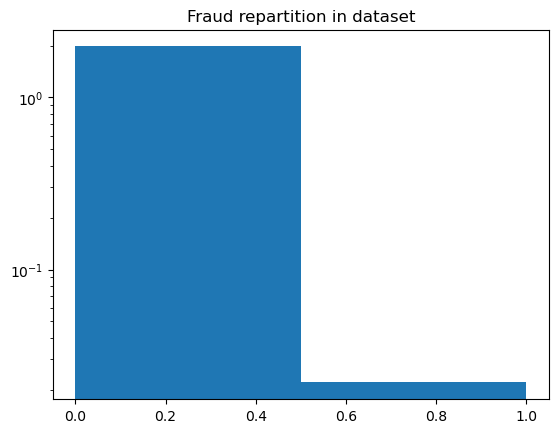

In [125]:
filepath = '../bank-account-fraud-dataset-neurips-2022/Base.csv'
df = pd.read_csv(filepath)

fraud = df["fraud_bool"].to_numpy()


class_weights = np.array([np.count_nonzero(fraud), len(fraud) - np.count_nonzero(fraud)])/len(fraud)
print("Repartition of fraud : {}% frauds, {}% non frauds".format(class_weights[0],class_weights[1]))

plt.yscale("log")
plt.hist(fraud, density= True, bins =2 )
plt.title("Fraud repartition in dataset")
plt.show()

In [126]:
s = (df.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols = list(s[s].index) # All the columns containing these features
print("All columns with categorical values")
print(df[object_cols])

for col in object_cols : 
    df_labels = df[col].str.get_dummies(' ')
    df = pd.concat([df,df_labels], axis = 1)
    df = df.drop([col],axis=1)


All columns with categorical values
       payment_type employment_status housing_status    source  device_os
0                AA                CA             BA  INTERNET    windows
1                AB                CA             BA  INTERNET    windows
2                AC                CB             BA  INTERNET      other
3                AB                CA             BA  INTERNET      linux
4                AB                CA             BA  INTERNET  macintosh
...             ...               ...            ...       ...        ...
999995           AB                CA             BC  INTERNET      linux
999996           AC                CC             BC  INTERNET    windows
999997           AA                CF             BC  INTERNET      other
999998           AA                CA             BA  INTERNET    windows
999999           AA                CA             BE  INTERNET      linux

[1000000 rows x 5 columns]


## Model design

The following methods will be used : 
- Logistic regression (with Cross-validation over parameters)
- KNN (with Cross-validation over parameters)
- Classifier (gaussian)
- Tree classifier (Random Forest)

To evaluate our models, we will use as scoring function F1 for the unbalanced fraud positive dataset and 

## Model development


In [127]:
# df.show()

In [128]:
# def score_classifier(X,estimator,parameters, y, scaler = StandardScaler()):

#     # search for best parameters
#     pipeline = Pipeline([('scaler', scaler), ('estimator', estimator)]) # scale training dataset and test dataset in folds independently
#     clf = GridSearchCV(pipeline, parameters, scoring ='f1', verbose =1)
#     clf.fit(X,y)

#     # evaluate best estimator
#     best_estimator = clf.best_estimator_
#     parameters = clf.best_params_
#     score = clf.best_score_
#     title = str(best_estimator)+'\n f1-score (CV): '+str(score)
#     y_pred = clf.predict(X) # same as best_estimator.predict(X)
#     cm = confusion_matrix(y, y_pred)
#     disp = ConfusionMatrixDisplay(cm)
#     disp.plot()
#     plt.title(title)
#     plt.show()
#     return(best_estimator, parameters, y_pred, score, cm)


In [129]:
# X = df.drop("FRAUD_BOOL").to_pandas()
# y = df.select("FRAUD_BOOL").to_pandas()


# class_weight = {1 : int(np.sum(y)), 0 : len(y) - int(np.sum(y))}
# plt.hist(y)
# plt.title(f'Repartition of fraud cases in the dataset \n{np.mean(y)}% fraud')


In [130]:
# df.select(list(numeric_cols)).to_pandas()

In [131]:
df = df.drop(['device_fraud_count'], axis = 1)

In [132]:
X = df.drop("fraud_bool", axis = 1)
y = df["fraud_bool"]

In [133]:
# X_train, X_test, y_train, y_test = train_test_split(X,y)
# numeric_cols = df.to_pandas().select_dtypes(include=['float64']).columns
# X_train = pd.DataFrame(X_train, df.columns)
# X_test = pd.DataFrame(X_test, df.columns)

# scaler = MinMaxScaler()
# X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
# X_test[numeric_cols] = scaler.fit(X_test[numeric_cols])


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
# numeric_cols = df.select_dtypes(=['float64']).columns
# X_train = pd.DataFrame(X_train, columns = df.columns)
# X_test = pd.DataFrame(X_test, df.columns)

numeric_cols = df.iloc[:,1:27].drop(['email_is_free','phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request','keep_alive_session'], axis = 1).columns

scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [135]:
# df.iloc[:,1:27].drop(['email_is_free','phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request','keep_alive_session'], axis = 1)

In [136]:
X_train

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,BE,BF,BG,INTERNET,TELEAPP,linux,macintosh,other,windows,x11
756697,0.000,0.856809,0.000000,0.256410,0.375,0.896374,0.109941,0.311138,0.339694,0.410508,...,0,0,0,1,0,1,0,0,0,0
202654,0.625,0.750462,0.081152,0.613054,0.500,0.000032,0.116860,0.181696,0.546682,0.537086,...,0,0,0,1,0,1,0,0,0,0
429390,0.000,0.352651,0.000000,0.855478,0.250,0.000027,0.117303,0.282472,0.078840,0.489674,...,1,0,0,1,0,1,0,0,0,0
145829,0.750,0.044935,0.031414,0.023310,0.250,0.000123,0.110640,0.107196,0.370158,0.537888,...,0,0,0,1,0,0,0,0,1,0
393932,0.250,0.612206,0.138743,0.839161,0.250,0.000167,0.116558,0.149149,0.812603,0.453327,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231718,0.875,0.651862,0.000000,0.687646,0.375,0.000221,0.871455,0.417737,0.167905,0.230438,...,0,0,0,1,0,0,0,1,0,0
274406,0.750,0.303719,0.000000,0.193473,0.125,0.000067,0.111391,0.304419,0.439302,0.440047,...,0,0,0,1,0,1,0,0,0,0
441854,1.000,0.409643,0.081152,0.326340,0.125,0.000174,0.112095,0.302180,0.485899,0.570523,...,1,0,0,1,0,0,0,1,0,0
668183,0.875,0.782727,0.000000,0.342657,0.250,0.000263,0.111244,0.516124,0.085169,0.696219,...,0,0,0,1,0,0,0,0,1,0


In [137]:

from sklearn.decomposition import PCA
n_before = X_train.shape[1]
pca = PCA(n_components=0.90)
X_train = pca.fit_transform(X_train, y_train)
print(f"Before PCA : {n_before} components \nAfter PCA : {pca.n_components_} components, explained variance : 0.9")
print("Explained variances : ", pca.explained_variance_ratio_)


Before PCA : 51 components 
After PCA : 21 components, explained variance : 0.9
Explained variances :  [0.08706069 0.08320431 0.07531517 0.07075482 0.06417383 0.05910908
 0.05676818 0.05562192 0.05059644 0.04508894 0.04235527 0.03436214
 0.03422471 0.03044945 0.0246358  0.01914326 0.01824357 0.01766836
 0.01525895 0.01498543 0.0129228 ]


In [138]:
X_test = pca.transform(X_test)

In [139]:
X_train.shape

(750000, 21)

In [140]:
y_train.shape

(750000,)

In [141]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [142]:
X_train.shape

(1483412, 21)

In [143]:
y_train

0          0
1          0
2          0
3          0
4          0
          ..
1483407    1
1483408    1
1483409    1
1483410    1
1483411    1
Name: fraud_bool, Length: 1483412, dtype: int64

In [144]:
# def score_classifier(estimator,parameters, X_train, y_train, scaler = StandardScaler()):

#     # search for best parameters
#     cv = StratifiedKFold(n_splits = 5, shuffle = True).split(X_train,y_train)
#     clf = GridSearchCV(estimator, parameters, scoring ='recall', verbose =1, cv = cv)
#     clf.fit(X_train,y_train)

#     # evaluate best estimator
#     best_estimator = clf.best_estimator_
#     parameters = clf.best_params_
#     score = clf.best_score_
#     print(f'Average score of the best estimator : {score}')
#     y_pred = clf.predict(X_test) # same as best_estimator.predict(X)
#     cm = confusion_matrix(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     disp = ConfusionMatrixDisplay(cm)
#     disp.plot()
#     title = str(estimator)+'\n f1-score on test dataset : '+str(f1)
#     plt.title(title)
#     plt.show()
#     return(best_estimator, parameters, y_pred, score, cm)


In [151]:
def score_classifier(estimator,parameters, X_train, y_train, X_test, y_test):

    # search for best parameters
    cv = StratifiedKFold(n_splits = 5, shuffle = True).split(X_train,y_train)
    clf = GridSearchCV(estimator, parameters, scoring ='f1', verbose = 1, cv = cv)
    clf.fit(X_train,y_train)

    # evaluate best estimator
    best_estimator = clf.best_estimator_
    parameters = clf.best_params_
    score = clf.best_score_
    print(f'Average f1-score of the best estimator : {score}')
    y_pred = clf.predict(X_train)
    rc = recall_score(y_test, y_pred)
    print(f'Recall score of the best estimator : {rc}')
    y_pred = clf.predict(X_test) # same as best_estimator.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    title = str(estimator)+'\n f1-score on test dataset : '+str(f1) +'\n recall on test dataset : '+str(rc)
    plt.title(title)
    plt.show()
    
    save(estimator,cm, rc)
    
    return(best_estimator, parameters, y_pred, score, cm)


In [157]:
results_dict = {}

def save(estimator,cm, rc)  : 
    results_dict[title] = {'cm' : cm, 'f1' : f1, 'rc' : rc}
    title = str(estimator)
    filename = f'../saved_models/{title}.sav'
    joblib.dump(model, filename)
    
    

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Average score of the best estimator : 0.7936271502018335


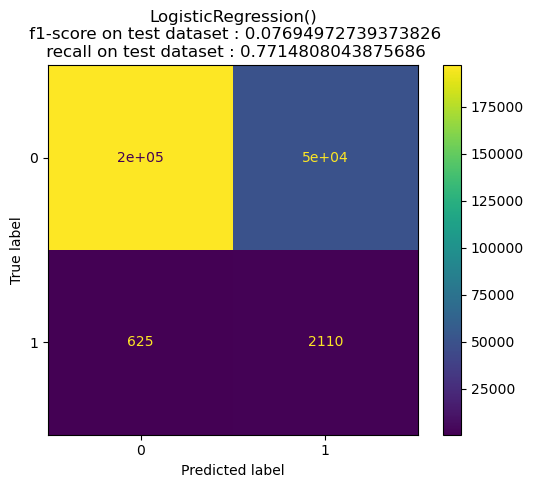

NameError: name 'joblib' is not defined

In [153]:
estimator = LogisticRegression()
parameters = {
    'penalty': ['l1', 'l2'],  # Regularization penalty: L1 or L2
    'C': [0.1, 1, 10],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # Solver algorithm: 'liblinear' for small datasets, 'saga' for large datasets
}
best_estimator, parameters, y_pred, score, cm = score_classifier(estimator,parameters, X_train, y_train, X_test, y_test)

# save(estimator,cm, rc)

In [156]:
print(results_dict)

{}


In [ ]:
parameters = {
    'n_estimators': [10, 50, 100],  # Number of trees in the random forest
    'max_depth': [5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': [0.99, 'sqrt'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}
estimator = RandomForestClassifier()
best_estimator, parameters, y_pred, score, cm = score_classifier(estimator,parameters, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
# df_pred = pd.DataFrame(pd.concat(X_test, y_test)).copy()
# session.write_pandas(df_pred, table_name='PREDICTIONS', auto_create_table=True, overwrite=True)
# df_pred = session.table('PREDICTIONS')
# df_pred.show()


# # To have the correct data types, we initialize the table
# estimator = LogisticRegression(verbose = 1)
# estimator.fit(X_train,y_train)
# y_pred = estimator.predict(X_test)
# score = f1_score(y_test, y_pred)
# cm = confusion_matrix(y_test,y_pred)
# parameters = estimator.get_params()

# df_score = pd.DataFrame(columns = ['estimator', 'parameters', 'score', 'tp', 'fp', 'fn', 'tn'])
# name = str(estimator)[:-11]
# row = [name, str(parameters), score, cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
# df_score.loc[0] = row

# session.write_pandas(df_score, table_name='SCORES', auto_create_table=True, overwrite=True)
# df_score = session.table('SCORES')

# def uppercase_all_columns(df: snowflake.snowpark.DataFrame) -> snowflake.snowpark.DataFrame:
#     return df.select([F.col(column).as_(column.upper()) for column in df.columns])
# df_score = uppercase_all_columns(df_score)
# df_score.write.save_as_table(table_name='SCORES', mode='overwrite')

# df_score = session.table('SCORES')
# df_score.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished
c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\snowflake\snowpark\session.py:1383: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


------------------------------------------------------------------------------------------------------------------------------------
|"ESTIMATOR"         |"PARAMETERS"                                        |"SCORE"             |"TP"    |"FP"    |"FN"    |"TN"    |
------------------------------------------------------------------------------------------------------------------------------------
|LogisticRegression  |{'C': 1.0, 'class_weight': None, 'dual': False,...  |0.5674273162498402  |537584  |451387  |418460  |570511  |
------------------------------------------------------------------------------------------------------------------------------------



In [ ]:
from snowflake.snowpark.functions import lit
from snowflake.snowpark import Row, Column

In [ ]:
def save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm):
    name = str(estimator)[:-11]
    session.sql("ALTER TABLE PREDICTIONS ADD COLUMN IF NOT EXISTS {} float(20)".format(name)).collect()
    df_pred = session.table('PREDICTIONS')


    row = [name, str(parameters), float(str(score)), cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
    df_score =df_score.to_pandas()
    df_score.loc[len(df_score)] = row
    print(df_score)
    session.write_pandas(df_score, table_name='SCORES', auto_create_table=True, overwrite=True)
    



In [ ]:
y = y.values.ravel()


In [18]:
estimator = LogisticRegression(verbose = 1)
parameters = {
    'estimator__penalty': ['l1', 'l2'],  # Regularization penalty: L1 or L2
    'estimator__C': [0.1, 1, 10],  # Inverse of regularization strength
    'estimator__solver': ['liblinear', 'saga']  # Solver algorithm: 'liblinear' for small datasets, 'saga' for large datasets
}
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

NameError: name 'X' is not defined

In [ ]:
estimator = KNeighborsClassifier(verbose = 1)
parameters = {
    'estimator__n_neighbors': [3, 5, 7],  # Number of neighbors to consider
    'estimator__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute nearest neighbors
    'estimator__p': [1, 2]  # Parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
parameters = {
    'estimator__C': [0.1, 1, 10],  # Regularization parameter
    'estimator__kernel': ['linear', 'rbf'],  # Kernel type: linear or radial basis function (RBF)
    'estimator__gamma': ['scale', 'auto'],  # Kernel coefficient for RBF
}
estimator = svm.SVC(verbose = 1)
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:

parameters = {
    'estimator__criterion': ['gini', 'entropy'],  # Split criterion: Gini impurity or information gain
    'estimator__max_depth': [None, 5, 10],  # Maximum depth of the tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'estimator__max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}
estimator = DecisionTreeClassifier(verbose = 1)
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

In [ ]:
parameters = {
    'estimator__n_estimators': [100, 200, 300],  # Number of trees in the random forest
    'estimator__max_depth': [None, 5, 10],  # Maximum depth of each tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'estimator__max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    'estimator__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}
estimator = RandomForestClassifier(verbose = 1)
best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from imblearn.over_sampling import SMOTE
import opendatasets as od
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from snowflake.snowpark import version
from snowflake.snowpark.functions import udf, sproc, col
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType, Variant

print(f"Snowflake snowpark version is: {version.VERSION}")

Snowflake snowpark version is: (1, 3, 0)


   FRAUD_BOOL  INCOME  NAME_EMAIL_SIMILARITY  PREV_ADDRESS_MONTHS_COUNT  \
0           0     0.8               0.700981                         -1   
1           0     0.8               0.443663                         29   
2           0     0.8               0.210539                         -1   
3           0     0.1               0.540481                        207   
4           0     0.1               0.865032                         -1   

   CURRENT_ADDRESS_MONTHS_COUNT  CUSTOMER_AGE  DAYS_SINCE_REQUEST  \
0                           122            20            0.024834   
1                             6            40            0.009049   
2                            13            40            0.006500   
3                            40            60            0.024999   
4                            35            30            0.033188   

   INTENDED_BALCON_AMOUNT  ZIP_COUNT_4W  VELOCITY_6H  ...  HOUSING_STATUS_BA  \
0               -0.392116          1703  7003.185343  

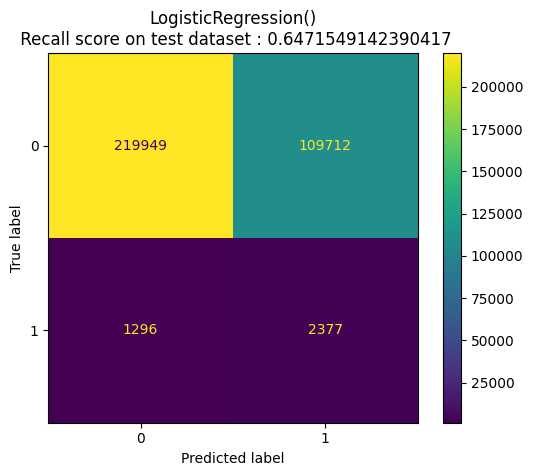

In [43]:
    table_name = 'CREDIT_RECORD'
    target = 'FRAUD_BOOL'
    clf = 'lr'


    # Load features
    df = session.table(table_name).to_pandas()
    print(df.head(), flush=True)
    X = df.drop(target, axis = 1)
    y = df[target]

    # Split dataset into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 42)
    X_train, y_train = SMOTE().fit_resample(X_train,y_train)

    # Preprocess numeric columns
    numeric_features = df.select_dtypes(include=['float64']).columns
    numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures(degree = 2)),('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

    
    def score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test):

        pipeline = Pipeline(steps=[('preprocessor', preprocessor),('pca', PCA(n_components = 0.9)),('estimator', estimator)])

        # search for best parameters
        cv = StratifiedKFold(n_splits = 5, shuffle = True).split(X_train,y_train)
        clf = GridSearchCV(pipeline, param_grid, scoring ='recall', verbose =1, cv = cv)
        clf.fit(X_train,y_train)

        # evaluate best estimator
        best_estimator = clf.best_estimator_
        parameters = clf.best_params_
        train_score = clf.best_score_
        print(f'Average score of the best estimator (training dataset) : {train_score}')
        y_pred = clf.predict(X_test) # same as best_estimator.predict(X)
        cm = confusion_matrix(y_test, y_pred)
        test_score = recall_score(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        title = str(estimator)+'\n Recall score on test dataset : '+str(test_score)
        plt.title(title)
        plt.show()
        return(best_estimator, parameters, y_pred, train_score, test_score, cm)

    # Create pipeline and train
    if clf == 'lr' : 

        estimator = LogisticRegression()
        param_grid = {
                'estimator__penalty': ['l1', 'l2'],  # Regularization penalty: L1 or L2
                'estimator__C': [0.1, 1, 10],  # Inverse of regularization strength
                'estimator__solver': ['liblinear', 'saga']  # Solver algorithm: 'liblinear' for small datasets, 'saga' for large datasets
        }   
        best_estimator, parameters, y_pred, train_score, test_score, cm = score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test)   
    
    if clf == 'svm' : 
        parameters = {
            'estimator__C': [0.1, 1, 10],  # Regularization parameter
            'estimator__kernel': ['linear', 'rbf'],  # Kernel type: linear or radial basis function (RBF)
            'estimator__gamma': ['scale', 'auto'],  # Kernel coefficient for RBF
        }
        estimator = svm.SVC()
        best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)


    if clf == 'dt' : 
        parameters = {
            'estimator__criterion': ['gini', 'entropy'],  # Split criterion: Gini impurity or information gain
            'estimator__max_depth': [5, 10],  # Maximum depth of the tree
            'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
            'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
            'estimator__max_features': [0.99, 'sqrt'],  # Number of features to consider when looking for the best split
        }
        estimator = DecisionTreeClassifier(verbose = 1)
        best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)

    
    if clf == 'rf' : 
        parameters = {
        'estimator__n_estimators': [10, 100],  # Number of trees in the random forest
        'estimator__max_depth': [5, 10],  # Maximum depth of each tree
        'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'estimator__max_features': [0.99, 'sqrt'],  # Number of features to consider when looking for the best split
        'estimator__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
        }
        estimator = RandomForestClassifier(verbose = 1)
        best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)


    if clf == 'lgb' : 
        estimator = lgb.LGBMClassifier()
        param_grid = {
            'estimator__boosting_type': ['gbdt', 'dart'],  # Boosting type: Gradient Boosting Decision Tree (gbdt) or Dart
            'estimator__num_leaves': [31, 63, 127],  # Maximum number of leaves in one tree
            'estimator__learning_rate': [1.0, 0.1, 0.01],  # Learning rate
            'estimator__subsample': [0.8, 1.0],  # Subsample ratio of the training instances
            'estimator__colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
            'estimator__reg_alpha': [0.0, 0.1, 0.5],  # L1 regularization term
            'estimator__reg_lambda': [0.0, 0.1, 0.5]  # L2 regularization term
        }

        best_estimator, parameters, y_pred, score, cm = score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test)


    # # Upload trained model to a stage
    # model_file = os.path.join('/tmp', str(estimator)+'.joblib')
    # dump(best_estimator, model_file)
    # session.file.put(model_file, "@ml_models",overwrite=True)

    # return {"Classifier tested" : str(estimator), "Recall score on Train": train_score,"R2 score on Test": test_score}


In [ ]:

# estimator = LogisticRegression()
# parameters = {
#     'estimator__penalty': ['l1', 'l2'],  # Regularization penalty: L1 or L2
#     'estimator__C': [0.1, 1, 10],  # Inverse of regularization strength
#     'estimator__solver': ['liblinear', 'saga']  # Solver algorithm: 'liblinear' for small datasets, 'saga' for large datasets
# }
# best_estimator, parameters, y_pred, score, cm = score_classifier(X, estimator, parameters, y)
# save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

In [13]:
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np

In [14]:
import opendatasets as od
import pandas as pd

In [16]:
import time
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline


In [17]:
# from snowflake.snowpark.session import Session
# from snowflake.snowpark.functions import udf, sproc, col
# from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType, Variant
# from snowflake.snowpark import functions as fn

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

# from snowflake.snowpark import version
# print(f"Snowflake snowpark version is : {version.VERSION}")